In [17]:
# Loan Default Prediction - End-to-End ML Pipeline with Gradio Interface
# 📦 Step 1: Import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.impute import SimpleImputer
import joblib
import gradio as gr

In [18]:
# 📥 Step 2: Load Dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
df = pd.read_csv(url)

In [19]:
# 🧹 Step 3: Data Cleaning / Preprocessing
df = df[['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Survived']]
df.dropna(subset=['Embarked'], inplace=True)

# 🚀 Step 4: Split Features and Target
X = df.drop('Survived', axis=1)
y = df['Survived']

In [20]:
# 🎯 Step 5: Define Preprocessing
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_features = ['Pclass', 'Sex', 'Embarked']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [21]:
# 🧠 Step 6: Define Model Pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42))
])

In [22]:
# 📊 Step 7: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [23]:
# 🔍 Step 8: Train the Model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [27]:
from sklearn.model_selection import GridSearchCV

- Perform hyperparameter tuning using GridSearchCV on the full ML pipeline.

- This automates model selection by training multiple models with different
- combinations of n_estimators and max_depth using 5-fold cross-validation.
- The best performing model (based on ROC AUC score) is saved as best_model.

In [29]:
# 🔍 Step 8: Grid Search Cross-Validation
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# ✅ Use Best Estimator
best_model = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}


In [30]:
# 📈 Step 9: Evaluation
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:, 1]

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.78      0.80       109
           1       0.68      0.74      0.71        69

    accuracy                           0.76       178
   macro avg       0.75      0.76      0.76       178
weighted avg       0.77      0.76      0.77       178

ROC AUC Score: 0.8439702167264992


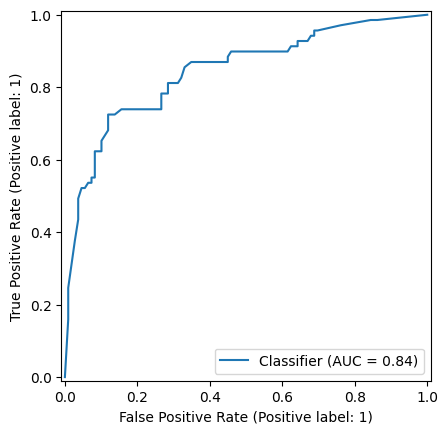

In [31]:
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))

RocCurveDisplay.from_predictions(y_test, y_proba)
plt.show()

In [32]:
# 💾 Step 10: Save Model
joblib.dump(pipeline, 'loan_default_model.joblib')

['loan_default_model.joblib']

In [34]:
# 📤 Step 11: Export Predictions
predictions_df = pd.DataFrame({
    'True Label': y_test,
    'Predicted': y_pred,
    'Probability': y_proba
})
predictions_df.to_csv('predictions.csv', index=False)

In [35]:
# 🤖 Step 12: Inference Interface with Gradio
model = joblib.load('loan_default_model.joblib')

def predict_survival(Pclass, Sex, Age, SibSp, Parch, Fare, Embarked):
    input_df = pd.DataFrame.from_dict({
        'Pclass': [Pclass],
        'Sex': [Sex],
        'Age': [Age],
        'SibSp': [SibSp],
        'Parch': [Parch],
        'Fare': [Fare],
        'Embarked': [Embarked]
    })
    pred = model.predict(input_df)[0]
    prob = model.predict_proba(input_df)[0][1]
    return f"Prediction: {'Survived' if pred==1 else 'Did Not Survive'} (Prob: {prob:.2f})"

demo = gr.Interface(
    fn=predict_survival,
    inputs=[
        gr.Dropdown([1, 2, 3], label="Pclass"),
        gr.Dropdown(["male", "female"], label="Sex"),
        gr.Number(label="Age", value=30),
        gr.Number(label="SibSp", value=0),
        gr.Number(label="Parch", value=0),
        gr.Number(label="Fare", value=50),
        gr.Dropdown(["C", "Q", "S"], label="Embarked")
    ],
    outputs="text",
    title="🚢 Titanic Survival Predictor",
    description="Enter passenger details to predict survival"
)

In [ ]:
# 🚀 Launch Gradio App
demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://f965b7ef33829fc9fc.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
